# **Regressão Logística from Scratch**
### **Heitor Barroso Cavalcante**

## **Bibliotecas utilizadas**

Para implementar esse projeto, utilizei as bibliotecas Pandas, para manipulação e importação dos dados; Numpy para efetuar manipulações matemáticas com vetores e matrizes e MatplotLib para visualizações.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IC/Ads_Rede_Social/Social_Network_Ads.csv')

Após importarmos os dados sobre anúncios em redes sociais, vamos, primeiramente, dar uma olhada em como esses dados estão configurados:

In [2]:
data.shape

(400, 4)

In [3]:
data.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


A partir dessa disposição em tabela e do formato dos dados importados, conseguimos concluir que há 400 exemplos que constituem pares de dados no seguinte formato: $(\textbf{x}_i, y_i), \; i = 1, \ldots, 400$, onde:
$$
\textbf{x}_i = \begin{bmatrix} x_{i,1} \\
x_{i,2} \\
x_{i,3}\end{bmatrix}
\; \text{ e } \; y_i \in \{0,1\}$$


Como dito no texto Fundamentos de Redes Neurais, as componentes do vetor de entrada $\textbf{x}_i$ podem ser variáveis numéricas, mas, também, categóricas e isso ocorre nesse dataset. 

Isso porque temos $\textbf{x}_i$ tal que:
* $x_{i,1}$ é o gênero (variável categórica) do $\text{consumidor}_i$
* $x_{i,2}$ é a idade (variável numérica) do $\text{consumidor}_i$
* $x_{i,3}$ é o salário (variável numérica) do $\text{consumidor}_i$

## **Implementação:**

Primeiramente, no caminho de implementar Regressão Logística, como há uma variável categórica envolvida nesse projeto, precisamos codificá-la de alguma maneira para que ela possa ser interpretada pelo modelo que estamos desenvolvendo.

Nesse caso, apesar de, em muitos momentos não ser indicado, utilizamos codificação numérica para representar os gêneros masculino e feminino. Mesmo assim, como poderemos enxergar, conseguiremos obter um desempenho satisfatório com a Regressão Logística implementada.

Nesse sentido, efetuamos a seguinte modificação nos dados que importamos:
$$
\text{Male} \rightarrow 0 \\
\text{Female} \rightarrow 1
$$

In [4]:
data = data.replace('Male', 1)
data = data.replace('Female', 0)
data.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


Agora, atribuímos às variáveis ${\tt X}$ e ${\tt Y}$ os importados

In [5]:
data_aux = np.array(data)
X = data_aux[:,(0,1,2)]
Y = data_aux[:,3]
print(X.shape)
print(Y.shape)

(400, 3)
(400,)


### **Normalização dos dados:**

De maneira análoga ao feito em Regressão Linear, iremos normalizar os dados da variável independente $\textbf{x}_i$. Contudo, diferentemente do caso anterior, diversas variáveis compõe $\textbf{x}_i$. Então, devemos normalizar cada valor: $x_{i,1},\;x_{i,2}\; \text{e} \; x_{i,3}$.

In [6]:
def normalize(X):
    m, n = X.shape     # m é número de exemplos de treinamento
                       # n é número de dimensões da entrada 
    for i in range(n): # Aqui normalizamos cada uma das dimensões da entrada
        X = (X - X.mean(axis=0))/X.std(axis=0)
        
    return X

In [7]:
X_normalizado = normalize(X)

Depois que normalizamos os dados, é possível visualizarmos esses dados. Para isso, cada exemplo $\textbf{x}_i$ será um ponto no $\mathbb{R}^3$ e sua cor indicará o valor de $y_i$.

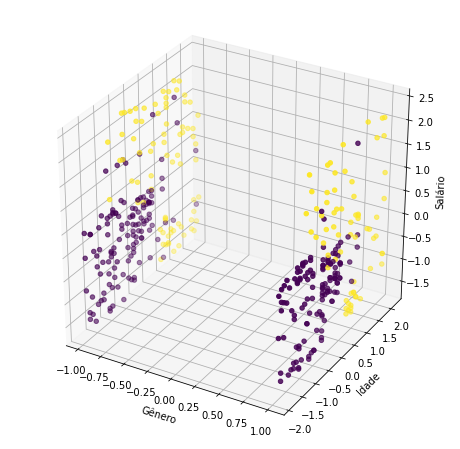

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

x_vals = X_normalizado[:,0]
y_vals = X_normalizado[:,1]
z_vals = X_normalizado[:,2]

ax.scatter(x_vals, y_vals, z_vals, c=Y)

ax.set_xlabel('Gênero')
ax.set_ylabel('Idade')
ax.set_zlabel('Salário')



plt.show()


### **Tratamento dos dados:**

Nesse ponto, devido à notação empregada no texto e no material do professor Yaser S. Abu-Mostafa, vamos inserir o elemento $x_0=1$ em cada exemplo $\textbf{x}_i$. Isso é feito com o método ${\tt ajeita\_dados(X,Y)}$.

Além disso, fazemos com que cada par de dados $(\textbf{x}_i, y_i)$ seja constituido de um vetor coluna ($\textbf{x}_i$) e, devido à implementação com Numpy, uma matriz $1 \times 1$ ($y_i$).

In [9]:
def ajeita_dados(X, Y):
  novo_X = []
  novo_Y = []
  for i in range(len(X)):
    aux = np.array(X[i])
    aux = np.insert(aux, 0, 1)
    aux = np.reshape(aux, (4, 1))
    novo_X.append(aux)
    novo_Y.append(np.reshape(Y[i], (1,1)))

  return np.array(novo_X), np.array(novo_Y)

In [10]:
X_util, Y_util = ajeita_dados(X_normalizado, Y)
print(X_util.shape, X_util[0].shape, Y_util.shape, Y_util[0].shape)

(400, 4, 1) (4, 1) (400, 1, 1) (1, 1)


### **Treinamento:**

Nessa célula está o coração da implementação da Regressão Logística.

O treinamento do modelo é feito, principalmente por meio do método ${\tt gradiente\_descendente(w,X,Y)}$. Nele, calculamos o gradiente da função de perda (${\tt dw}$). 

Depois, atualizamos o vetor de pesos $\textbf{w}$.

Além disso, para que esse processo seja realizado, definimos a função sigmoide para realizarmos o cálculo $\sigma(\textbf{w}^T\mathbf{\tilde{x}})$.

In [11]:
def sigmoide(z):
    return (1/(1 + np.exp(-z)))


def gradient_descendente(w, X, Y):
  N = len(Y)
  dw = np.zeros(shape=(4,1))
  for i in range(N):
    y_hat = sigmoide(np.dot(w.T, X[i]))
    dw += X[i]*(y_hat - Y[i])
  return dw/N


def update_params(w, dw, eta):
  return w - (dw * eta)


def treinamento(epochs, eta, X, Y):
  w = np.zeros(shape=(4,1))
  for epoch in range(epochs):
    if epoch % 5000 == 0: print(f"Epoch={epoch}")
    dw = gradient_descendente(w, X, Y)
    w = update_params(w, dw, eta)
  return w

Quanto ao método ${\tt treinamento(epochs, eta, X, Y)}$, definimos quantas vezes o modelo será atualizado (${\tt epochs}$), a taxa de aprendizado ($\eta$) e mandamos o conjunto de treinamento (${\tt X\_util}$ e ${\tt Y\_util}$). Ao final das iterações, esse método retorna o último vetor de pesos $\mathbf{w}$ obtido.

In [12]:
w = treinamento(5000, 0.1, X_util, Y_util)
print(w)

Epoch=0
[[-1.15546722]
 [ 0.16688794]
 [ 2.48101095]
 [ 1.24097826]]


In [13]:
w[0].item()

-1.1554672235262544

Em regressão Logística, os valores preditos $\hat{y}_i$ são probabilidades. Portanto, para compararmos $\hat{y}_i$ e $y_i$ e chegarmos à conclusões sobre o desempenho da regressão, definimos o limiar de $0.5$ para binarizarmos $\hat{y}_i$.

Dessa forma, para cada $\hat{y}_i$ criamos ${\tt y\_pred[i]}$. 

Assim, se $\hat{y}_i \geq 0.5$ então ${\tt y\_pred[i]} \leftarrow 1$ e se $\hat{y}_i < 0.5$ então ${\tt y\_pred[i]} \leftarrow 0$.

In [14]:
y_pred= []
for i in range(len(X)):
    y_hat = sigmoide(np.dot(w.T, X_util[i]))
    y_pred.append(1) if y_hat>=0.5 else  y_pred.append(0)      

### **Desempenho do modelo obtido:**

Para obter uma métrica sobre o desempenho do modelo obtido – em relação ao conjunto de treinamento – comparamos os valores ${\tt y\_pred[i]}$ e $y_i$ para chegarmos ao valor de acurácia do modelo.

In [15]:
count = 0
for x in range(len(y_pred)):
    if(y_pred[x]==Y[x]):
        count=count+1
print('Accuracy:',(count/(len(y_pred)))*100)

Accuracy: 85.25


Por fim, podemos utilizar o vetor de pesos $\mathbf{w}$ obtido para produzir o plano separador dos dados de entrada $\mathbf{x}_i$ e plotá-lo.

Observe o gráfico.

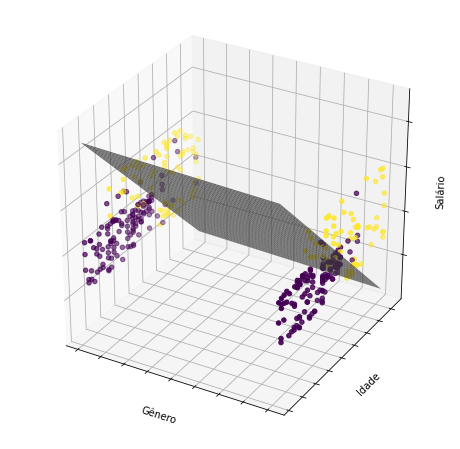

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

x_vals = X_normalizado[:,0]
y_vals = X_normalizado[:,1]
z_vals = X_normalizado[:,2]

ax.scatter(x_vals, y_vals, z_vals, c=Y)

ax.set_xlabel('Gênero')
ax.set_ylabel('Idade')
ax.set_zlabel('Salário')

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])


x_var = np.linspace(np.amin(x_vals), np.amax(x_vals), 100)
y_var = np.linspace(np.amin(y_vals), np.amax(y_vals), 100)

x_var, y_var = np.meshgrid(x_var, y_var)
eq = (-(w[2].item()*y_var)-(w[1].item()*x_var)-w[0].item())/(w[3].item())

ax.plot_surface(x_var, y_var, eq, color="gray", alpha=0.8)



plt.show()